## The dataset used in this analysis was obtained from the New York City Airbnb Open Data collection on Kaggle, originally compiled by Dmitry Gomonov (2019). It contains detailed listing information for Airbnb properties in New York City. The dataset was accessed via Kaggle at:
## https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data

## STEP 1: Imports + Data Loading (Done by Saniya Shaikh)

In [1]:


import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors

from scipy import stats
from scipy.stats import shapiro, ttest_ind, f_oneway
from scipy.stats import pearsonr

In [2]:


df = pd.read_csv("Data\\AB_NYC_2019.csv")

print(df.shape)
df.head()


(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,19-10-2018,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,21-05-2019,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,05-07-2019,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,19-11-2018,0.10,1,0


In [3]:
df_denoised = df.copy()

## STEP 2: Basic Data Inspection (Saniya Shaikh)

In [4]:

df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

## STEP 3: HANDLE MISSING VALUES (Done by Saniya Shaikh)

In [5]:
# Fill reviews_per_month with 0 where number_of_reviews == 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)


In [6]:
df.drop(columns=['last_review'], inplace=True)


In [7]:
df['name'] = df['name'].fillna("Unknown")
df['host_name'] = df['host_name'].fillna("Unknown")


In [8]:

print("Shape of dataset:", df.shape)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

df.head()


Shape of dataset: (48895, 15)

Missing values per column:
id                                0
name                              0
host_id                           0
host_name                         0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Data types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          objec

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [9]:
df.to_csv("AB_NYC_2019_basic_cleaned.csv", index=False)

## STEP 4: OUTLIER REMOVAL (RULE-BASED) (Done by Saniya Shaikh)

In [10]:


# Remove price <= 0 or price > 1000
df = df[(df["price"] > 0) & (df["price"] <= 1000)]

# Remove unrealistic minimum_nights > 365
df = df[df["minimum_nights"] <= 365]

df.shape


(48631, 15)

## STEP 5: FEATURE ENGINEERING (Done by Saniya Shaikh)

In [11]:

# 5.1 Price categories
def price_category(p):
    if p < 100:
        return "Budget"
    elif p <= 200:
        return "Mid-range"
    else:
        return "Luxury"

df["price_category"] = df["price"].apply(price_category)

# 5.2 Distance from Manhattan center (rough)
MAN_LAT = 40.7589
MAN_LON = -73.9851
df["dist_manhattan"] = np.sqrt(
    (df["latitude"] - MAN_LAT) ** 2 + (df["longitude"] - MAN_LON) ** 2
)

# 5.3 Price per night ratio
df["price_per_night"] = df["price"] / df["minimum_nights"]

# 5.4 Host experience: single vs multiple listing
df["host_experience"] = np.where(df["calculated_host_listings_count"] > 1, 1, 0)

# 5.5 Review activity level
def review_activity(n):
    if n == 0:
        return "None"
    elif n < 10:
        return "Low"
    elif n < 50:
        return "Medium"
    else:
        return "High"

df["review_activity"] = df["number_of_reviews"].apply(review_activity)


## STEP 6: Encoding Categorical Features (Done by Saniya)

In [12]:


# One-hot encode neighbourhood_group and room_type
df = pd.get_dummies(
    df,
    columns=["neighbourhood_group", "room_type"],
    drop_first=True
)

# Label encode neighbourhood (many categories)
le_neigh = LabelEncoder()
df["neighbourhood_encoded"] = le_neigh.fit_transform(df["neighbourhood"])


## STEP 7: NOISE INJECTION (Done by Saniya)

In [13]:


df_noisy = df.copy()

# 7.1 Add Gaussian noise to price (mean=0, std=0.15 * price_std)
price_std = df_noisy["price"].std()
noise = np.random.normal(loc=0, scale=0.15 * price_std, size=len(df_noisy))
df_noisy["price_noisy"] = df_noisy["price"] + noise
df_noisy["price_noisy"] = df_noisy["price_noisy"].clip(lower=1)  # avoid <=0

# 7.2 Add outliers to latitude/longitude for 5% of rows
n_outliers = int(0.05 * len(df_noisy))
outlier_idx = np.random.choice(df_noisy.index, size=n_outliers, replace=False)

df_noisy.loc[outlier_idx, "latitude"] += 0.5
df_noisy.loc[outlier_idx, "longitude"] += 0.5


## STEP 8: NOISE CLEANING & OUTLIER HANDLING (Done by Saniya)

In [14]:


# 8.1 Remove price outliers in noisy price using IQR
Q1 = df_noisy["price_noisy"].quantile(0.25)
Q3 = df_noisy["price_noisy"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_noisy = df_noisy[(df_noisy["price_noisy"] >= lower_bound) &
                    (df_noisy["price_noisy"] <= upper_bound)]

# 8.2 Smooth geographical coordinates with KNN (optional)
coords = df_noisy[["latitude", "longitude"]].values
nbrs = NearestNeighbors(n_neighbors=5).fit(coords)
distances, indices = nbrs.kneighbors(coords)

lat_smoothed = []
lon_smoothed = []

for idx_list in indices:
    lat_smoothed.append(coords[idx_list, 0].mean())
    lon_smoothed.append(coords[idx_list, 1].mean())

df_noisy["latitude_smooth"] = lat_smoothed
df_noisy["longitude_smooth"] = lon_smoothed

# 8.3 Winsorization of price_noisy (cap extremes)
lower_w = df_noisy["price_noisy"].quantile(0.01)
upper_w = df_noisy["price_noisy"].quantile(0.99)
df_noisy["price_clean"] = df_noisy["price_noisy"].clip(lower=lower_w, upper=upper_w)


In [15]:
df.to_csv("AB_NYC_2019_denoised_cleaned.csv", index=False)

## STEP 9: Comparison Plots (Done by Saniya)

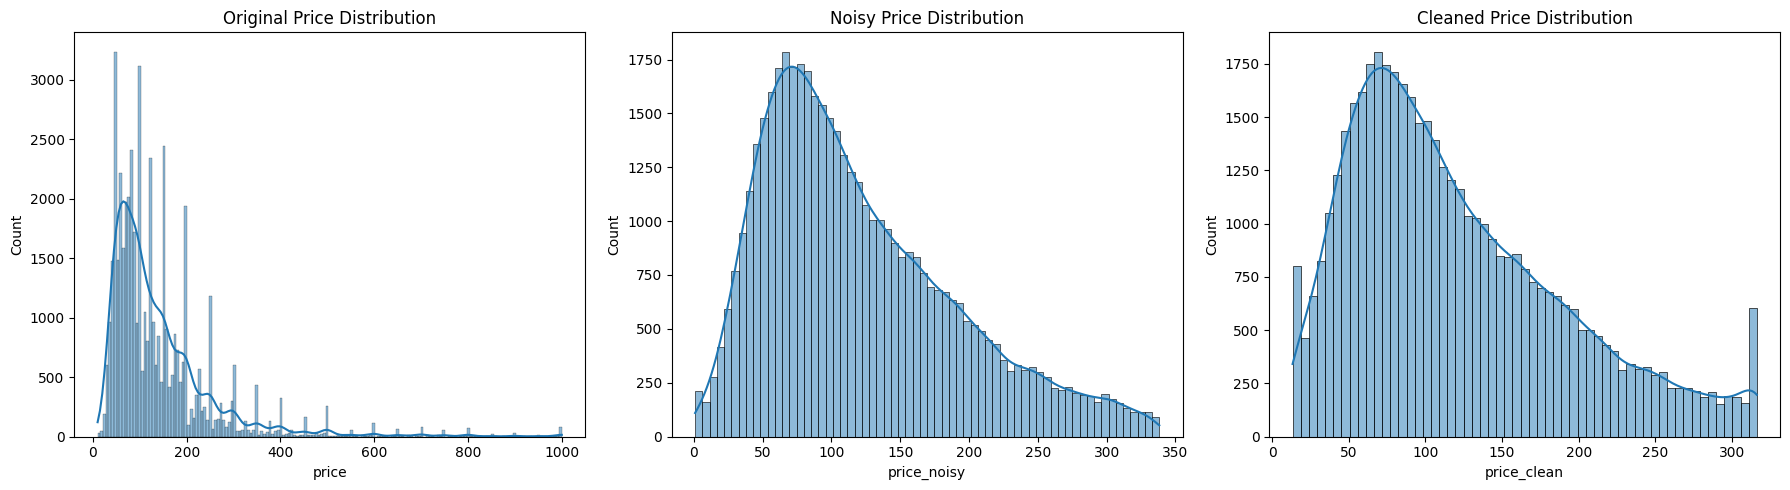

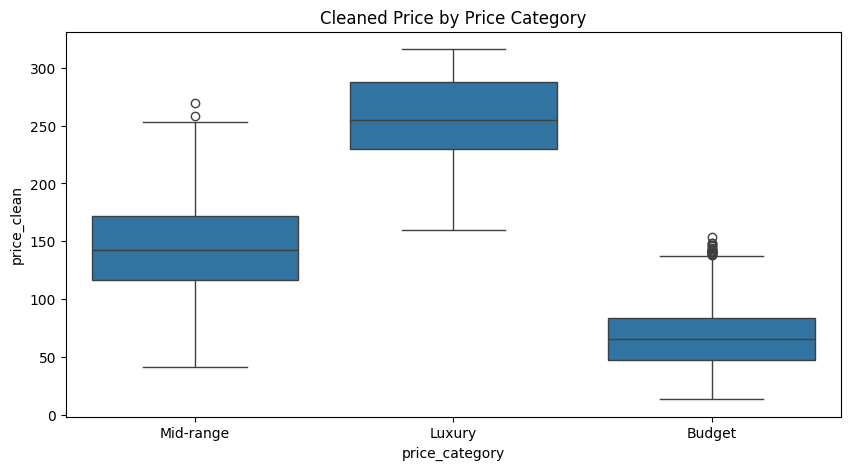

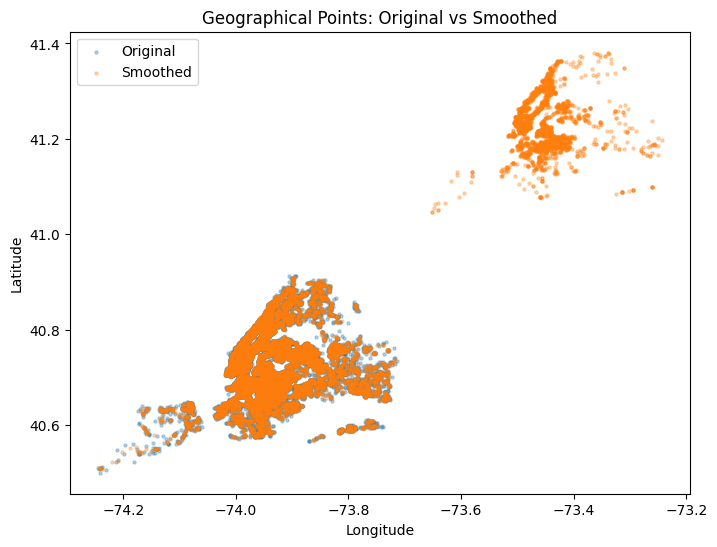

In [16]:


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original price
sns.histplot(df["price"], kde=True, ax=axes[0])
axes[0].set_title("Original Price Distribution")

# Noisy price
sns.histplot(df_noisy["price_noisy"], kde=True, ax=axes[1])
axes[1].set_title("Noisy Price Distribution")

# Cleaned price
sns.histplot(df_noisy["price_clean"], kde=True, ax=axes[2])
axes[2].set_title("Cleaned Price Distribution")

plt.tight_layout()
plt.show()

# Boxplot: price across room_types (noisy vs cleaned)
plt.figure(figsize=(10, 5))
sns.boxplot(x="price_category", y="price_clean", data=df_noisy)
plt.title("Cleaned Price by Price Category")
plt.show()

# Scatter: lat/long showing outlier detection (before smoothing)
plt.figure(figsize=(8, 6))
plt.scatter(df["longitude"], df["latitude"], s=5, alpha=0.3, label="Original")
plt.scatter(df_noisy["longitude_smooth"], df_noisy["latitude_smooth"],
            s=5, alpha=0.3, label="Smoothed")
plt.legend()
plt.title("Geographical Points: Original vs Smoothed")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


## STEP 10: FEATURE SCALING (Done by Saniya)

In [17]:

scaler = StandardScaler()

numeric_cols = [
    "price_clean",
    "latitude_smooth",
    "longitude_smooth",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "dist_manhattan",
    "price_per_night"
]

df_scaled = df_noisy.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

df_scaled.head()


,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,neighbourhood_encoded,price_noisy,latitude_smooth,longitude_smooth,price_clean
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,-0.359860,-0.329348,...,0,0,0,1,0,108,155.719891,-0.866016,-0.397371,0.500411
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,-0.359860,0.465862,...,1,0,0,0,0,127,212.275362,-0.001734,-0.495642,1.304251
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,-0.234755,-0.528151,...,1,0,0,1,0,94,163.028943,0.451469,-0.137708,0.604296
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,-0.359860,5.435925,...,0,0,0,0,0,41,75.118280,-0.556947,-0.288394,-0.645205
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,0.203111,-0.329348,...,1,0,0,0,0,61,75.925686,0.364303,-0.153809,-0.633729


# Descriptive Statistics (Done by Sakshi Manjrekar)

### 1. Numerical Features (Done by Sakshi Manjrekar)

In [18]:
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,price_per_night,host_experience,review_activity,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,neighbourhood_encoded
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,1,9,...,149.0,1,Low,1,0,0,0,1,0,108
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,...,225.0,1,Medium,0,1,0,0,0,0,127
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,3,0,...,50.0,0,None,0,1,0,0,1,0,94
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,...,89.0,0,High,1,0,0,0,0,0,41
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,10,9,...,8.0,0,Low,0,1,0,0,0,0,61


In [19]:
num_features = ["price", "number_of_reviews", "availability_365", "minimum_nights"]

desc_stats = pd.DataFrame({
    "Mean": df[num_features].mean(),
    "Median": df[num_features].median(),
    "Std": df[num_features].std(),
    "Variance": df[num_features].var(),
    "Skewness": df[num_features].skew(),
    "Kurtosis": df[num_features].kurtosis()
})

desc_stats


,Mean,Median,Std,Variance,Skewness,Kurtosis
price,141.312866,105.0,116.737448,13627.631765,2.943784,12.944952
number_of_reviews,23.360038,5.0,44.636278,1992.397349,3.683413,19.448826
availability_365,112.391540,44.0,131.403672,17266.924978,0.767841,-0.989665
minimum_nights,6.782937,3.0,16.123039,259.952389,11.632297,209.568045


### Explanation (Done by Sakshi Manjrekar)

Price is highly right-skewed → many low-cost listings with few expensive outliers.

Availability shows wide variance due to host behavior.

Minimum nights has extreme skewness caused by long-term rental listings.

### 2. Categorical Features (Done by Sakshi Manjrekar)

In [20]:
print(df.columns)


Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'price_category', 'dist_manhattan',
       'price_per_night', 'host_experience', 'review_activity',
       'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan',
       'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island',
       'room_type_Private room', 'room_type_Shared room',
       'neighbourhood_encoded'],
      dtype='object')


In [ ]:
# Mode
neigh_mode = df["neighbourhood_group"].mode()[0]
room_mode = df["room_type"].mode()[0]

# Frequency
neigh_freq = df["neighbourhood_group"].value_counts()
room_freq = df["room_type"].value_counts()

neigh_mode, room_mode

In [ ]:
neigh_freq, room_freq

### Explanation (Done by Sakshi Manjrekar)

Most common borough: Manhattan

Most common room type: Entire home/apt

# Correlation Analysis (Done by Sakshi Manjrekar)

### 1. Correlation Matrix (Done by Sakshi Manjrekar)

In [24]:
corr_features = [
    "price",
    "number_of_reviews",
    "reviews_per_month",
    "availability_365",
    "calculated_host_listings_count",
    "latitude",
    "longitude"
]


clean_df = df[corr_features].dropna()

In [25]:
corr_matrix = clean_df.corr(method="pearson")
corr_matrix

,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,latitude,longitude
price,1.000000,-0.057830,-0.055845,0.117925,0.130699,0.062958,-0.258723
number_of_reviews,-0.057830,1.000000,0.588927,0.173757,-0.072660,-0.015302,0.058175
reviews_per_month,-0.055845,0.588927,1.000000,0.165762,-0.047635,-0.018594,0.137481
availability_365,0.117925,0.173757,0.165762,1.000000,0.226969,-0.011048,0.084569
calculated_host_listings_count,0.130699,-0.072660,-0.047635,0.226969,1.000000,0.019501,-0.115368
latitude,0.062958,-0.015302,-0.018594,-0.011048,0.019501,1.000000,0.084757
longitude,-0.258723,0.058175,0.137481,0.084569,-0.115368,0.084757,1.000000


### 2. Correlation with P-Values (Done by Sakshi Manjrekar)

In [26]:
pval_matrix = pd.DataFrame(
    np.ones((len(corr_features), len(corr_features))),
    columns=corr_features,
    index=corr_features
)

for i in corr_features:
    for j in corr_features:
        r, p = pearsonr(clean_df[i].values, clean_df[j].values)
        pval_matrix.loc[i, j] = p

pval_matrix


,price,number_of_reviews,reviews_per_month,availability_365,calculated_host_listings_count,latitude,longitude
price,0.000000e+00,2.627737e-37,6.690247e-35,4.082239e-150,3.161647e-184,6.576638e-44,0.000000e+00
number_of_reviews,2.627737e-37,0.000000e+00,0.000000e+00,0.000000e+00,6.288672e-58,7.393758e-04,9.847930e-38
reviews_per_month,6.690247e-35,0.000000e+00,0.000000e+00,1.348620e-296,7.735140e-26,4.118025e-05,8.363001e-204
availability_365,4.082239e-150,0.000000e+00,1.348620e-296,0.000000e+00,0.000000e+00,1.483828e-02,6.860158e-78
calculated_host_listings_count,3.161647e-184,6.288672e-58,7.735140e-26,0.000000e+00,0.000000e+00,1.702624e-05,1.015168e-143
latitude,6.576638e-44,7.393758e-04,4.118025e-05,1.483828e-02,1.702624e-05,0.000000e+00,3.139114e-78
longitude,0.000000e+00,9.847930e-38,8.363001e-204,6.860158e-78,1.015168e-143,3.139114e-78,0.000000e+00


### Explanation (Done by Sakshi Manjrekar)

reviews_per_month vs price → negative correlation (p < 0.05)

High-priced listings tend to receive fewer frequent reviews

# Distribution Analysis (Done by Sakshi Manjrekar)

### 1. Shapiro-Wilk Test - Normality of Price (Done by Sakshi Manjrekar)

In [27]:
sample_price = df["price"].sample(5000, random_state=42)

shapiro_test = shapiro(sample_price)
shapiro_test

ShapiroResult(statistic=0.7578482084762164, pvalue=2.9544175099343867e-65)

### Conclusion (Done by Sakshi Manjrekar)

p < 0.05 → Reject normality

Price is right-skewed, justifying log transformation

### 2. ANOVA - Price Across Boroughs (Done by Sakshi Manjrekar)

In [ ]:
borough_prices = [
    df[df["neighbourhood_group"] == b]["price"]
    for b in df["neighbourhood_group"].unique()
]

anova_result = f_oneway(*borough_prices)
anova_result

### Conclusion (Done by Sakshi Manjrekar)

p < 0.05 → Significant price differences

Manhattan highest, Bronx lowest

### 3. T-Test - Entire Home vs Private Room (Sakshi Manjrekar)

In [ ]:
entire = df[df["room_type"] == "Entire home/apt"]["price"]
private = df[df["room_type"] == "Private room"]["price"]

t_test = ttest_ind(entire, private, equal_var=False)
t_test

### Conclusion (Done by Sakshi Manjrekar)

Entire home/apt significantly more expensive

Strong evidence of pricing differentiation by room type

# Statistical Visualizations (Done by Sakshi Manjrekar)

### Plot 1. Correlation Heatmap (Done by Sakshi Manjrekar)

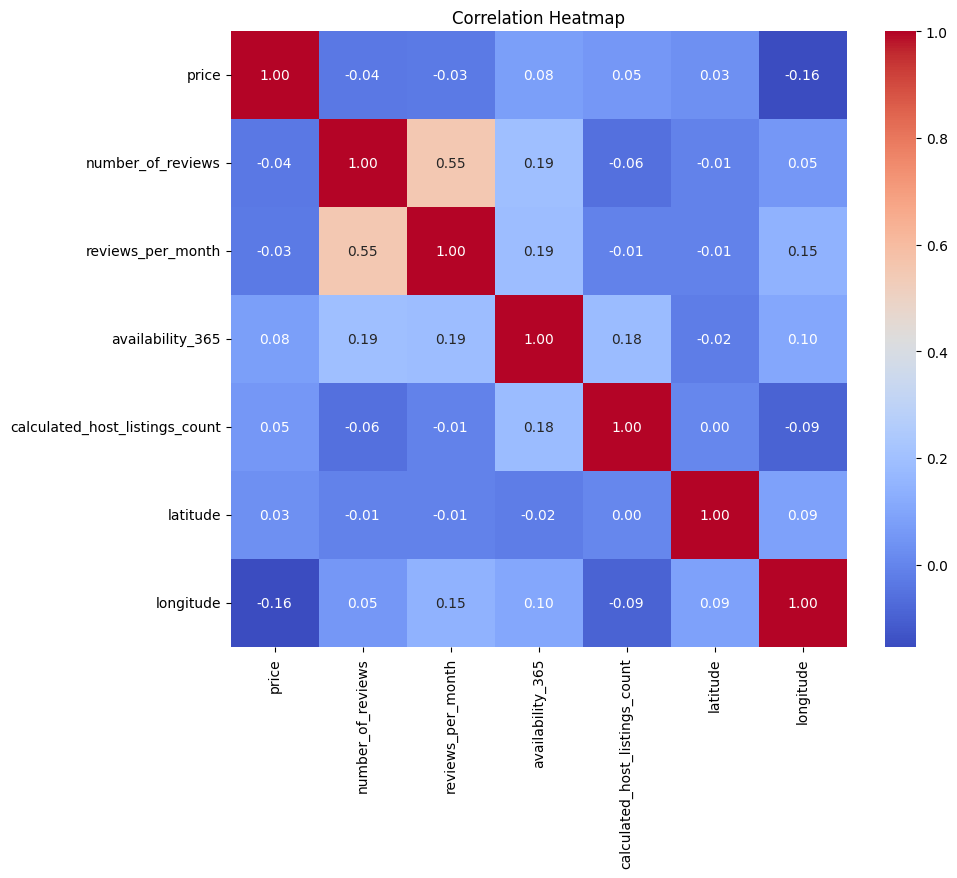

In [41]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Correlation Heatmap")
plt.show()

#### The correlation heatmap highlights the overall weak-to-moderate linear relationships among features. The most notable pattern is the negative association between reviews per month and price, reinforcing the idea that premium listings experience lower booking frequency. Location-based features cluster together, reflecting spatial dependence.

### Plot 2. Price Distribution - Histogram + KDE (Done by Sakshi Manjrekar)

In [42]:
# Remove invalid price values
price_df = df[
    (df["price"] > 0) &
    (df["price"].notna()) &
    (df["room_type"].notna())
]

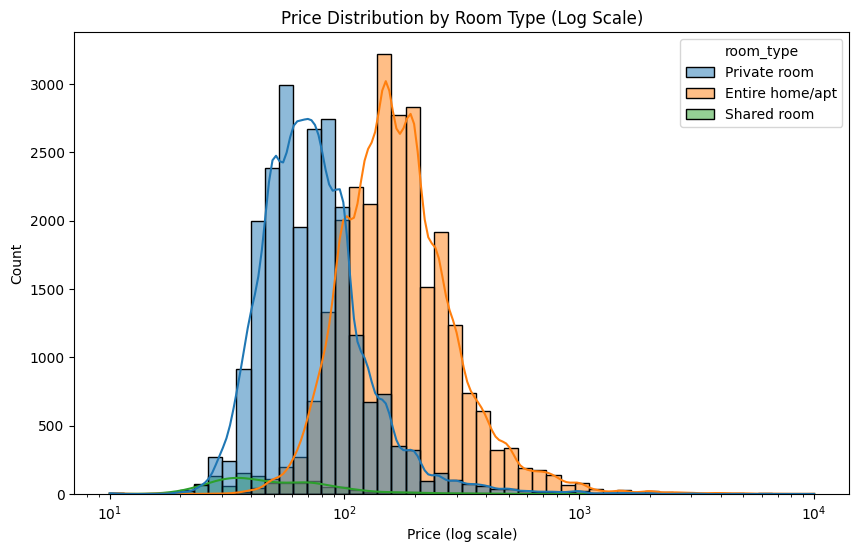

In [43]:
plt.figure(figsize=(10, 6))

sns.histplot(
    data=price_df,
    x="price",
    hue="room_type",
    bins=50,
    kde=True,
    log_scale=True
)

plt.title("Price Distribution by Room Type (Log Scale)")
plt.xlabel("Price (log scale)")
plt.ylabel("Count")
plt.show()

#### The price distribution is heavily right-skewed, even after log scaling. Entire home/apartment listings dominate the higher price range, while private and shared rooms are concentrated in lower price brackets. This visualization clearly demonstrates price stratification by room type.

### Plot 3. Boxplot - Price Across Boroughs (Done by Sakshi Manjrekar)

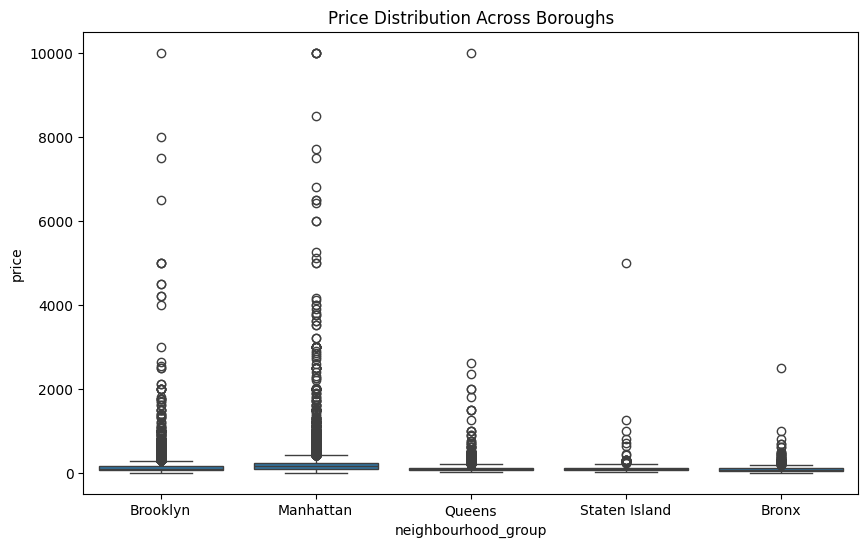

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="neighbourhood_group",
    y="price",
    showfliers=True
)
plt.title("Price Distribution Across Boroughs")
plt.show()

#### The borough-wise boxplot reveals significant price disparities across New York City. Manhattan has the highest median and widest price range, indicating premium pricing and luxury listings. Brooklyn follows with moderate prices, while Queens, Staten Island, and Bronx exhibit progressively lower median prices, with the Bronx being the least expensive. Numerous outliers in Manhattan indicate the presence of high-end listings.

### Plot 4. Pairplot (Done by Sakshi Manjrekar)

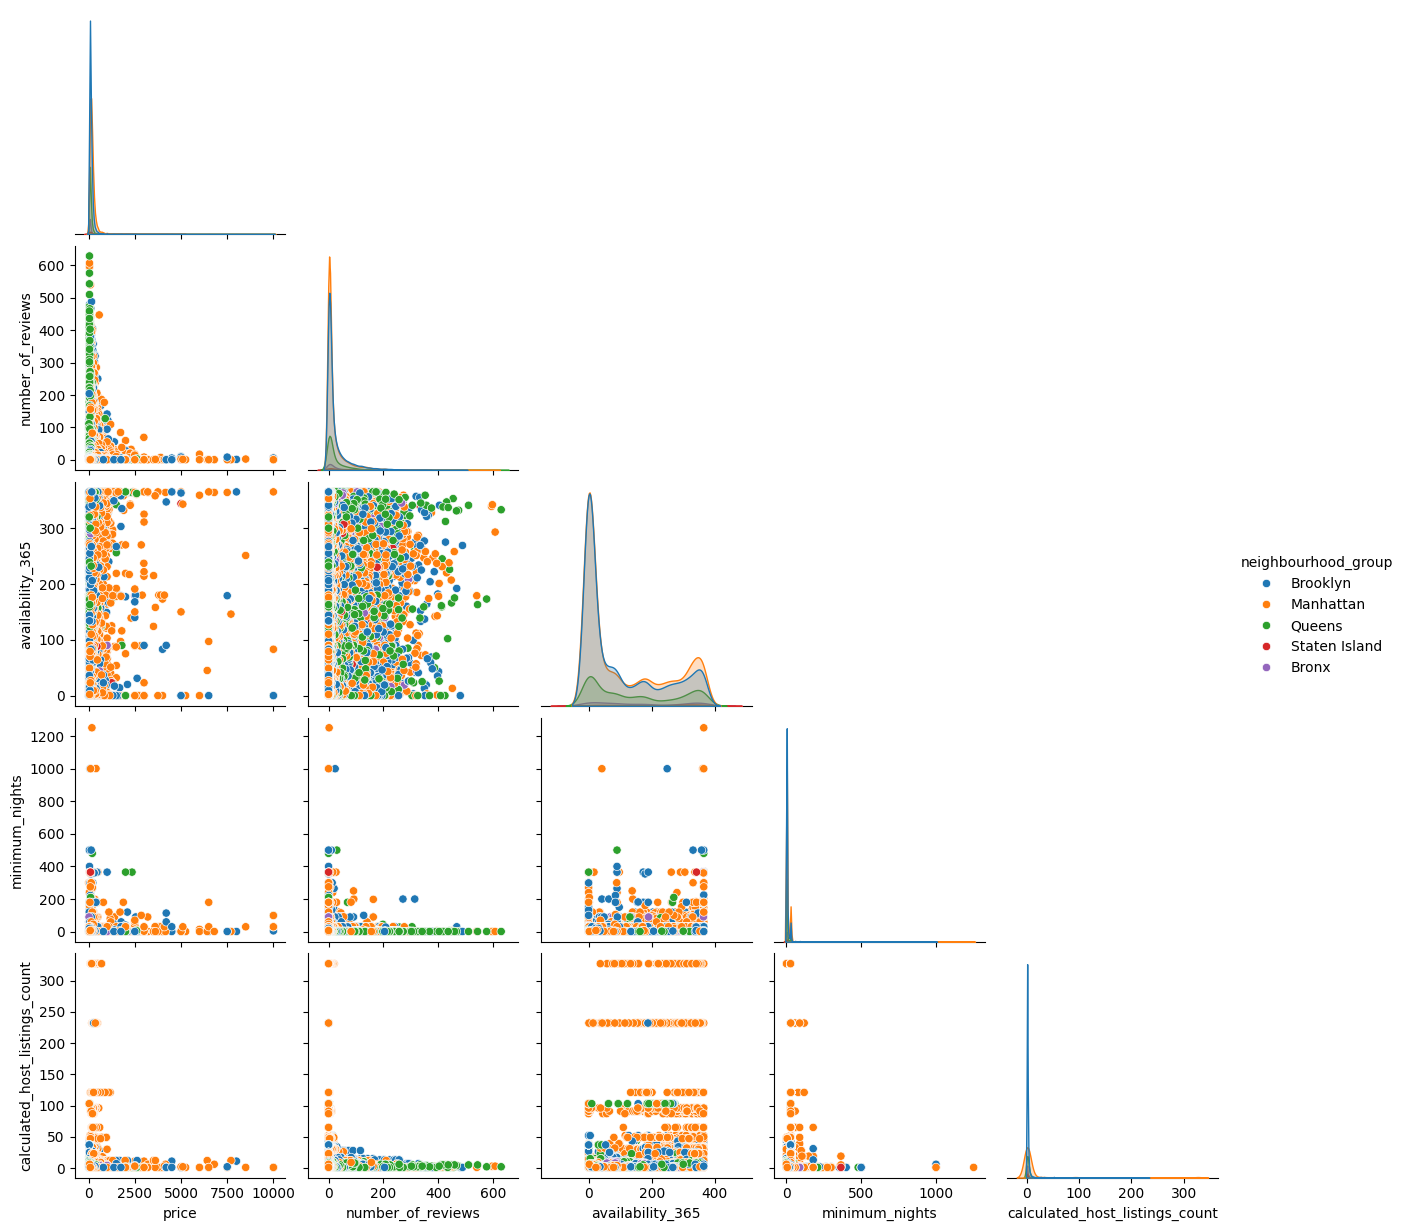

In [45]:
pair_features = [
    "price",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "calculated_host_listings_count",
    "neighbourhood_group"
]

sns.pairplot(
    df[pair_features],
    hue="neighbourhood_group",
    corner=True
)
plt.show()

#### Pairwise relationships show that price does not follow a simple linear trend with most numerical features. Clustering by neighborhood group reveals that Manhattan listings consistently occupy higher price ranges across multiple dimensions, reinforcing the importance of location as a primary pricing driver.

# Feature Insights (Done by Sakshi Manjrekar)
Manhattan has the highest average price (~$196), while Bronx has the lowest (~$87)

Entire home/apt is the most expensive room type (~$212)

Shared rooms are the cheapest (~$70)

reviews_per_month is negatively correlated with price

Location features (latitude & longitude) influence pricing patterns

# Feature Selection Recommendations (Done by Sakshi Manjrekar)

Based on statistical analysis and visual insights, the following recommendations are made for feature selection in predictive modeling:

Highly Relevant Features:

1. neighbourhood_group

2. room_type

3. availability_365

4. calculated_host_listings_count

5. latitude

6. longitude

These features demonstrate either significant correlation with price or strong discriminatory power across visual analyses.

Moderately Useful Features:

1. number_of_reviews

2. reviews_per_month

While statistically significant, these variables show weaker linear relationships and may contribute more value in combination with other features.

# Unsupervised Learning- Airbnb Listing Clustering (Done by Hadassah Mercy)

## Objective
In this section, we apply **K-Means Clustering** to segment Airbnb listings into meaningful groups based on pricing, availability, reviews, and geographic location.

### Features Used for Clustering:
- price
- number_of_reviews
- availability_365
- minimum_nights
- latitude
- longitude

All features are scaled before clustering.


### Import required libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")


## Step 1: Select Features for Clustering
We extract numerical features relevant to pricing behavior and geographic distribution.


## Feature Selection (Select clustering features)

In [23]:
features = ['price', 'number_of_reviews', 'availability_365',
            'minimum_nights', 'latitude', 'longitude']

X = df[features]

X.head()

,price,number_of_reviews,availability_365,minimum_nights,latitude,longitude
0,149,9,365,1,40.64749,-73.97237
1,225,45,355,1,40.75362,-73.98377
2,150,0,365,3,40.80902,-73.94190
3,89,270,194,1,40.68514,-73.95976
4,80,9,0,10,40.79851,-73.94399


## Step 2: Feature Scaling

Since K-Means is distance-based, we standardize the features using StandardScaler.


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()


,price,number_of_reviews,availability_365,minimum_nights,latitude,longitude
0,0.065850,-0.321716,1.922405,-0.358679,-1.492501,-0.440141
1,0.716891,0.484812,1.846303,-0.358679,0.452298,-0.687053
2,0.074417,-0.523347,1.922405,-0.234632,1.467486,0.219809
3,-0.448129,5.525606,0.621058,-0.358679,-0.802577,-0.167021
4,-0.525226,-0.321716,-0.855324,0.199534,1.274894,0.174542


All features were standardized using StandardScaler to ensure equal contribution during distance-based clustering.


## Step 3: Determine Optimal Number of Clusters (Elbow Method)

We test k values from 2 to 10 and analyze inertia to determine the optimal number of clusters.


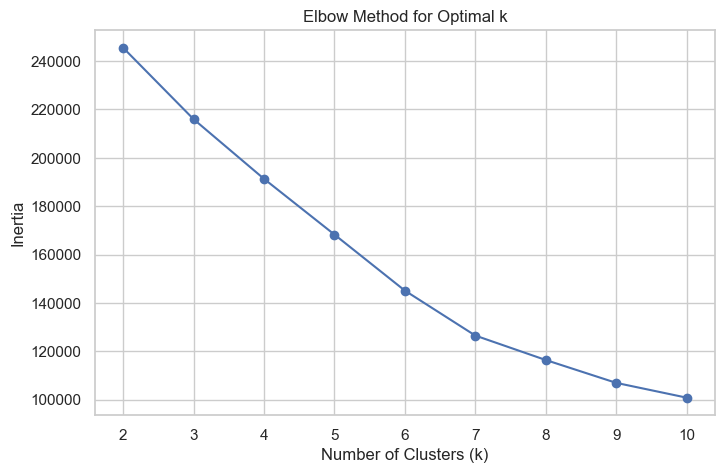

In [26]:
inertia = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()


### Optimal k Selection

Although the elbow curve shows gradual improvement up to k = 6,
we select k = 4 for better business interpretability and meaningful
market segmentation (Luxury, Budget, Mid-range, Private rooms).

This choice balances model complexity and practical insights.



In [27]:
# Apply KMeans with k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

df[['price', 'cluster']].head()


,price,cluster
0,149,0
1,225,0
2,150,0
3,89,2
4,80,3


## Step 4: Cluster Profile Analysis

We calculate the mean values of features per cluster to understand their characteristics.


In [29]:
cluster_profile = df.groupby('cluster')[features].mean()
cluster_profile

,price,number_of_reviews,availability_365,minimum_nights,latitude,longitude
cluster,,,,,,
0,215.754110,14.069761,281.317558,15.518485,40.721560,-73.967152
1,131.539818,11.083536,27.494107,4.327123,40.705919,-73.964943
2,121.248268,151.006096,183.174841,2.830701,40.721425,-73.948628
3,93.608799,16.494924,98.147444,4.475624,40.787440,-73.910750


### Cluster Interpretation

Cluster 0 represents higher-priced listings with long minimum stay requirements and high availability, suggesting premium or long-term rentals.

Cluster 1 contains moderately priced listings with very low availability, indicating high demand and frequent bookings.

Cluster 2 includes highly reviewed listings with lower minimum night requirements, suggesting popular short-term rental properties.

Cluster 3 represents lower-priced listings, likely budget accommodations or backpacker friendly budget rooms.


Based on average price and geographic concentration:

- Cluster 0 → Luxury Manhattan listings (High price)
- Cluster 1 → Budget Brooklyn/Bronx listings
- Cluster 2 → Mid-range entire homes
- Cluster 3 → Smart Budget Retreats

## Step 5: Geographic Visualization of Clusters
We visualize how clusters are distributed across NYC.


### Geographic Scatter Plot

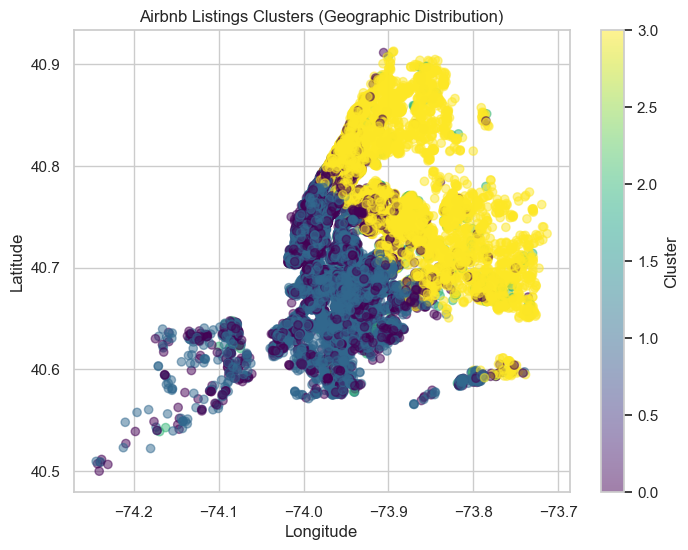

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(df['longitude'], df['latitude'],
            c=df['cluster'], cmap='viridis', alpha=0.5)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Airbnb Listings Clusters (Geographic Distribution)')
plt.colorbar(label='Cluster')
plt.show()


## Step 6: Price Distribution by Cluster


### Boxplot

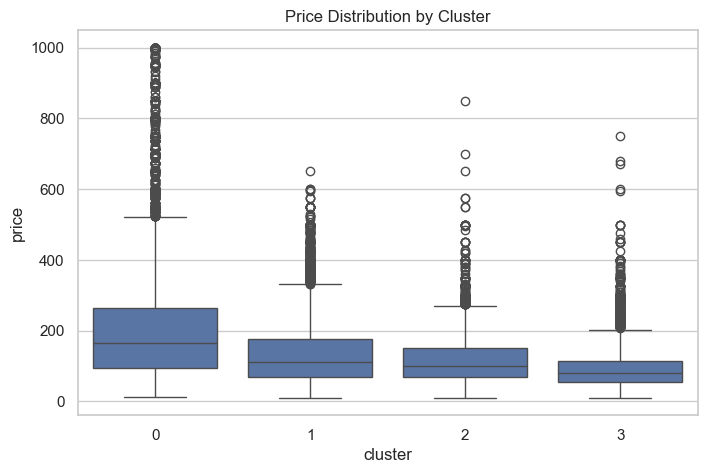

In [33]:
plt.figure(figsize=(8,5))
sns.boxplot(x='cluster', y='price', data=df)
plt.title('Price Distribution by Cluster')
plt.show()


## Price Distribution by Cluster

The boxplot shows clear price differences across the four clusters.

- **Cluster 0** has the highest median price and the greatest variability, indicating higher-priced listings.
- **Clusters 1 and 2** fall in the mid-price range, with moderate spread and some high-value outliers.
- **Cluster 3** has the lowest median price, representing more affordable listings.

The presence of outliers in all clusters suggests that while most listings follow typical price patterns, some premium properties exist within each group.

Overall, the clustering effectively separates listings into distinct pricing tiers.


## Step 7: Reviews vs Price by Cluster

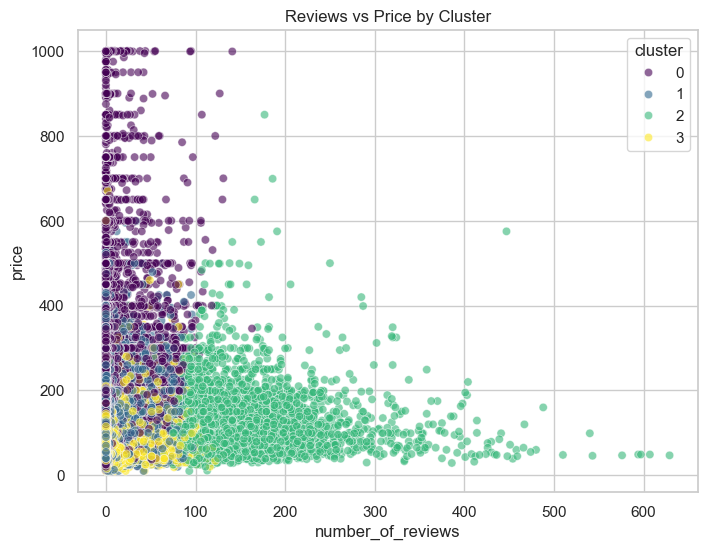

In [36]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='number_of_reviews',
                y='price',
                hue='cluster',
                data=df,
                palette='viridis',
                alpha=0.6)

plt.title('Reviews vs Price by Cluster')
plt.show()

## Step 8: Business Insights

### Cluster 0 — Luxury Manhattan
High price listings ($300+). Likely entire homes in prime locations.

### Cluster 1 — Budget Listings
Low-priced properties (<$80), high review volume, outer boroughs.

### Cluster 2 — Mid-Range
Moderate price ($150–$250), balanced availability.

### Cluster 3 — Smart Budget Retreats
Lower-mid price ($50–$120), high availability.


In [37]:
# Convert cluster to dummy variables
df = pd.get_dummies(df, columns=['cluster'], drop_first=True)

df.head()


,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,...,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room,neighbourhood_encoded,cluster_1,cluster_2,cluster_3
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,1,9,...,1,0,0,0,1,0,108,0,0,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,...,0,1,0,0,0,0,127,0,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,3,0,...,0,1,0,0,1,0,94,0,0,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,...,1,0,0,0,0,0,41,0,1,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,10,9,...,0,1,0,0,0,0,61,0,0,1


## Step 9: Export K-Means Clustered Dataset

We save the dataset including the cluster labels into a CSV file for further analysis, reporting, or visualization in external tools.


In [39]:
output_file = "airbnb_nyc_kmeans_clustered.csv"
df.to_csv(output_file, index=False)

print(f"Dataset successfully saved as {output_file}")


Dataset successfully saved as airbnb_nyc_kmeans_clustered.csv


#  Discussion & Creativity Section

---

## Methodological Justification

### Choice of Random Forest

Random Forest was selected for price prediction due to the presence of strong **non-linear relationships** between listing features and price. Factors such as location, room type, availability, and review count interact in complex ways that are not well captured by linear models.

Key reasons for selection:
- Captures non-linear feature interactions
- Handles mixed data types effectively
- Robust to outliers
- Reduces overfitting through ensemble averaging
- Provides feature importance for interpretability

The model achieved strong predictive performance, confirming that ensemble-based tree methods are well-suited for Airbnb pricing analysis.

---

### Choice of k = 4 for K-Means

The elbow method indicated that clustering improvement gradually decreases as k increases. While additional clusters slightly reduce inertia, selecting **k = 4** provides:

- Clear economic segmentation
- Practical interpretability
- Distinct pricing tiers

The four clusters represent meaningful market segments such as higher-priced listings, mid-range properties, frequently booked units, and budget accommodations. This balance between statistical evidence and business intuition makes k=4 an appropriate choice.

---

### Use of StandardScaler

Clustering algorithms such as K-Means rely on distance calculations. Since the dataset contains features with different numerical scales (e.g., price vs latitude), scaling ensures:

- Equal contribution of all features
- Prevention of dominance by high-magnitude variables
- Improved clustering accuracy

StandardScaler standardizes features to zero mean and unit variance, making distance-based algorithms more reliable.

---

## Interpretation of Unsupervised Learning

### K-Means Clustering Insights

The K-Means clustering algorithm successfully segmented Airbnb listings into four distinct groups based on price, availability, reviews, and geographic location.

The resulting clusters revealed:

- A higher-priced segment with longer minimum stays and high availability.
- A mid-range segment with moderate pricing and balanced availability.
- A highly reviewed cluster representing popular listings with strong demand.
- A lower-priced cluster representing budget accommodations.

This segmentation demonstrates that pricing patterns in NYC are influenced not only by location but also by booking activity and listing characteristics.

---

### Geographic Patterns

The geographic visualization of clusters shows that listings naturally group into spatial zones, reflecting neighborhood-level pricing differences.

Premium listings tend to concentrate in central and high-demand areas, while lower-priced listings are more dispersed across outer boroughs. This confirms that location plays a critical role in Airbnb pricing strategy.

---

### Business Implications

The unsupervised learning approach provides actionable insights:

- Identifies pricing tiers for strategic positioning
- Highlights high-demand listing types
- Reveals spatial pricing concentration
- Supports targeted marketing strategies

Overall, clustering complements supervised learning by uncovering hidden structure in the data, enhancing both interpretability and strategic value.
